# Ejercicio 5: Charles Darwin was right!

Decimar la imágen de un mono

In [1]:
from PIL import Image
from typing import Callable
from pathlib import Path

In [2]:
ASSETS_FOLDER_PATH = "./assets"
OUTPUT_FOLDER_PATH = "./ex5"

In [3]:
Path(OUTPUT_FOLDER_PATH).mkdir(parents=True, exist_ok=True)

## Carga de imágen

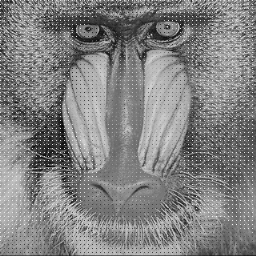

In [4]:
im = Image.open(f"{ASSETS_FOLDER_PATH}/mono.bmp")
im

## Funciones para descomponer y recomponer imágenes en bloques

In [5]:
def blockify(image: Image.Image, block_size: int) -> list[list[Image.Image]]:
    if image.height % block_size != 0 or image.height % block_size != 0:
        raise ValueError('image is not divisible by block_size')

    block_mat: list[list[Image.Image]] = []

    n_rows = int(image.height / block_size)
    n_cols = int(image.width / block_size)

    for n_row in range(n_rows):
        block_mat.append([])

        for n_col in range(n_cols):
            curr_left_pixel_pos = n_col * block_size
            curr_top_pixel_pos = n_row * block_size

            next_left_pixel_pos = ((n_col+1) * block_size)
            next_top_pixel_pos = ((n_row+1) * block_size)

            curr_right_pixel_pos = next_left_pixel_pos
            curr_bottom_pixel_pos = next_top_pixel_pos

            block = image.crop((
                curr_left_pixel_pos, 
                curr_top_pixel_pos,
                curr_right_pixel_pos,
                curr_bottom_pixel_pos
            ))

            block_mat[n_row].append(block)
            
    return block_mat

In [6]:
def deblockify(block_mat: list[list[Image.Image]], mode: str) -> Image.Image:
    n_rows = len(block_mat)
    n_cols = len(block_mat[0])

    block_width = block_mat[0][0].width
    block_height = block_mat[0][0].height

    width = block_width * n_cols
    height = block_height * n_rows

    image = Image.new(mode, size=(width, height))

    curr_left_pixel = 0
    curr_top_pixel = 0
    for n_row in range(n_rows):
        next_top_pixel = curr_top_pixel + block_height
        curr_bottom_pixel = next_top_pixel

        for n_col in range(n_cols):
            block = block_mat[n_row][n_col]
            
            next_left_pixel = curr_left_pixel + block_width
            curr_right_pixel = next_left_pixel

            image.paste(block, (curr_left_pixel, curr_top_pixel, curr_right_pixel, curr_bottom_pixel))
            
            curr_left_pixel = next_left_pixel
        
        curr_top_pixel = next_top_pixel
        curr_left_pixel = 0
            
    return image

### Checkeo de idempotencia

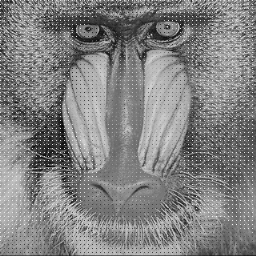

In [7]:
deblockify(blockify(im, 4), im.mode)

## Funciones para decimación

In [8]:
def decimate(image: Image.Image, block_size: int, decimation_strategy: Callable[[Image.Image], Image.Image]) -> Image.Image:
    block_mat = blockify(image, block_size)

    decimated_block_mat: list[list[Image.Image]] = []
    for n_row in range(len(block_mat)):
        decimated_block_mat.append([])
        
        for n_col in range(len(block_mat[n_row])):
            block = block_mat[n_row][n_col]
            decimated_block = decimation_strategy(block)

            decimated_block_mat[n_row].append(decimated_block)

    image = deblockify(decimated_block_mat, image.mode)
    
    return image

### Estrategias de decimación

In [9]:
def pixel_picker_block_decimation(picked_pixel: tuple[int, int], block: Image.Image) -> Image.Image:
    curr_left = picked_pixel[1]
    curr_top = picked_pixel[0]
    curr_right = curr_left+1
    curr_bottom = curr_top+1
    
    decimated_block = block.crop((
        curr_left,
        curr_top,
        curr_right,
        curr_bottom
    ))

    return decimated_block

In [10]:
def avg_pixel_block_decimation(block: Image.Image) -> Image.Image:
    if block.mode != "L":
        raise ValueError('image must be in L mode to perform this decimation strategy')
    
    n_pixels = block.width * block.height
    sum_pixels = 0

    pixels = block.load()
    for x_pos in range(block.width):
        for y_pos in range(block.height):
            sum_pixels += pixels[x_pos, y_pos]

    avg_pixels = int(sum_pixels / n_pixels)

    return Image.new(mode=block.mode, size=(1, 1), color=avg_pixels)

## Experimentos

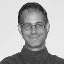

In [11]:
a = decimate(im, 4, lambda block: pixel_picker_block_decimation((0, 0), block))
a.save(f"{OUTPUT_FOLDER_PATH}/a.bmp")
a

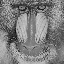

In [12]:
b = decimate(im, 4, lambda block: pixel_picker_block_decimation((1, 1), block))
b.save(f"{OUTPUT_FOLDER_PATH}/b.bmp")
b

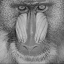

In [13]:
c = decimate(im, 4, avg_pixel_block_decimation)
c.save(f"{OUTPUT_FOLDER_PATH}/c.bmp")
c

## Conclusiones